In [91]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt

In [92]:
class RBM:
        def __init__(self,
                 n_visible,
                 n_hidden,
                 learning_rate=0.01,
                 momentum=0.95,
                 use_tqdm=False,
                 tqdm=None    
                ):
            
            self._use_tqdm = use_tqdm
            self._tqdm = None

            if use_tqdm or tqdm is not None:
                from tqdm import tqdm
            self._tqdm = tqdm
            self.n_visible = n_visible
            self.n_hidden = n_hidden
            self.learning_rate = learning_rate 
            self.momentum = momentum
            #initial weights

            self.w = tf.Variable(tf.zeros([self.n_visible, self.n_hidden]), dtype=tf.float32)
            self.visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
            self.hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)
            
            self.delta_w = tf.Variable(tf.zeros([self.n_visible, self.n_hidden]), dtype=tf.float32)
            self.delta_visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
            self.delta_hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)

            
        def contrastive_divergence(self,batch_x):
            
            
            g = tf.Variable(tf.zeros([self.n_visible, self.n_hidden]), dtype=tf.float32)
            g_vb = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
            g_hb = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)
            for i in range(10):
                self.x=batch_x[i].reshape(1,28*28)
                
                hidden_p = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
                hidden_p = self.sample_prob(hidden_p)
                
                visible_recon_p = tf.nn.sigmoid(tf.matmul(sample_bernoulli(hidden_p), tf.transpose(self.w)) + self.visible_bias)
                hidden_recon_p = tf.nn.sigmoid(tf.matmul(visible_recon_p, self.w) + self.hidden_bias)

                positive_grad = tf.matmul(tf.transpose(self.x), hidden_p)
                negative_grad = tf.matmul(tf.transpose(visible_recon_p), hidden_recon_p)

                
                #compute gradient
                delta_w_new = self.learning_rate*(positive_grad - negative_grad)
                delta_visible_bias_new = self.learning_rate*(tf.reduce_mean(self.x - visible_recon_p, 0))
                delta_hidden_bias_new = self.learning_rate*(tf.reduce_mean(hidden_p - hidden_recon_p, 0))
                
                update_delta_w = self.delta_w.assign(delta_w_new)
                update_delta_visible_bias = self.delta_visible_bias.assign(delta_visible_bias_new)
                update_delta_hidden_bias = self.delta_hidden_bias.assign(delta_hidden_bias_new)
                
                #Accumulate
                g=g+update_delta_w
                g_vb=g_vb+update_delta_visible_bias
                g_hb=g_hb+update_delta_hidden_bias
                
            #Update Parameter
            update_w = self.w.assign(self.w + g/10)
            update_visible_bias = self.visible_bias.assign(self.visible_bias + g_vb/10)
            update_hidden_bias = self.hidden_bias.assign(self.hidden_bias + g_hb/10)

            self.update_deltas = [update_delta_w, update_delta_visible_bias, update_delta_hidden_bias]
            self.update_weights = [update_w, update_visible_bias, update_hidden_bias]

        
        def sample_prob(self, probs):
            return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))    
        
        def reconstruct(self,batch_x):
        
            hidden = tf.nn.sigmoid(tf.matmul(batch_x, (self.update_weights[0])) 
                                   + (self.update_weights[2]))
            hidden = self.sample_prob(hidden)
            visible = tf.nn.sigmoid(tf.matmul(hidden, tf.transpose((self.update_weights[0]))) 
                                    + (self.update_weights[1]))
            return visible
        
        def get_err(self,batch_x):
            
            error=0
            for i in range(10):
                self.x=batch_x[i].reshape(1,28*28)
                
                self.compute_hidden = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
                self.compute_visible = tf.nn.sigmoid(tf.matmul(self.compute_hidden, tf.transpose(self.w)) + self.visible_bias)
                error=error+tf.reduce_mean(tf.square(self.x - self.compute_visible))
            
            self.compute_err = error/10  
            
            return self.compute_err
        
        def get_reconstruction_cross_entropy(self,batch_x):
            
            hidden = tf.nn.sigmoid(tf.matmul(batch_x, (self.update_weights[0])) 
                                   + (self.update_weights[2]))
            hidden = self.sample_prob(hidden)
            
            visible = tf.nn.sigmoid(tf.matmul(hidden, tf.transpose((self.update_weights[0]))) 
                                    + (self.update_weights[1]))

            cross_entropy = -tf.reduce_mean(tf.reduce_sum(batch_x * np.log(visible) 
                                                    +(1 - batch_x) * np.log(1-visible),axis=1))

            return cross_entropy 
        
        def fit(self,
                data_x,
                n_epoches=10,
                batch_size=10,
                shuffle=True,
                verbose=True):
            assert n_epoches > 0

            n_data = data_x.shape[0]

            if batch_size > 0:
                n_batches = n_data // batch_size + (0 if n_data % batch_size == 0 else 1)
            else:
                n_batches = 1

            if shuffle:
                data_x_cpy = data_x.copy()
                inds = np.arange(n_data)
            else:
                data_x_cpy = data_x

            errs = []

            for e in range(n_epoches):
                if verbose:
                    print('Epoch: {:d}'.format(e))

                epoch_errs = np.zeros((n_batches,))
                epoch_errs_ptr = 0

                if shuffle:
                    np.random.shuffle(inds)
                    data_x_cpy = data_x_cpy[inds,:,:]

                r_batches = range(n_batches)

                if verbose and self._use_tqdm:
                    r_batches = self._tqdm(r_batches, desc='Epoch: {:d}'.format(e), ascii=True, file=sys.stdout)

                for b in r_batches:
                    batch_x = data_x_cpy[b * batch_size:(b + 1) * batch_size]
                    self.contrastive_divergence(batch_x)
                    batch_err = self.get_err(batch_x)
                    epoch_errs[epoch_errs_ptr] = batch_err
                    epoch_errs_ptr += 1


                if verbose:
                    err_mean = epoch_errs.mean()
                    if self._use_tqdm:
                        self._tqdm.write('Train error: {:.4f}'.format(err_mean))
                        self._tqdm.write('')
                    else:
                        print('Train error: {:.4f}'.format(err_mean))
                        print('')
                    sys.stdout.flush()

                errs = np.hstack([errs, epoch_errs])

            return errs
     

In [93]:
def sample_bernoulli(probs):
    return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs)))) 

In [94]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train_complete, x_test_complete = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train_complete))
print("Number of original test examples:", len(x_test_complete))

Number of original training examples: 60000
Number of original test examples: 10000


In [95]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [96]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [97]:
THRESHOLD = 0.5
import numpy as np
import numpy
#binarizing the image 0, 1
x_train = numpy.array(x_train > THRESHOLD, dtype=np.float32)
x_test = numpy.array(x_test > THRESHOLD, dtype=np.float32)

y_train = numpy.array(y_train > THRESHOLD, dtype=np.float32)
y_test = numpy.array(y_test > THRESHOLD, dtype=np.float32)

In [98]:
mnist_train=(x_train,y_train)

In [99]:
print(mnist_train[0][:12040,:,:].shape)

(12040, 28, 28)


In [100]:
bbrbm = RBM(n_visible=784, n_hidden=64, learning_rate=0.01,momentum=0.95,use_tqdm=True)

In [101]:
err=bbrbm.fit(mnist_train[0][:12040,:,:])

Epoch: 0
Epoch: 0: 100%|####################################################################| 1204/1204 [00:34<00:00, 35.21it/s]
Train error: 0.0703

Epoch: 1
Epoch: 1: 100%|####################################################################| 1204/1204 [00:34<00:00, 35.18it/s]
Train error: 0.0515

Epoch: 2
Epoch: 2: 100%|####################################################################| 1204/1204 [00:34<00:00, 34.89it/s]
Train error: 0.0463

Epoch: 3
Epoch: 3: 100%|####################################################################| 1204/1204 [00:34<00:00, 35.15it/s]
Train error: 0.0429

Epoch: 4
Epoch: 4: 100%|####################################################################| 1204/1204 [00:34<00:00, 35.01it/s]
Train error: 0.0405

Epoch: 5
Epoch: 5: 100%|####################################################################| 1204/1204 [00:34<00:00, 34.96it/s]
Train error: 0.0387

Epoch: 6
Epoch: 6: 100%|####################################################################| 1204/1

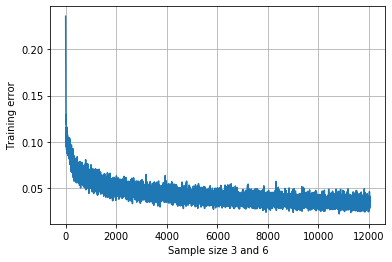

In [102]:
plt.plot(err)

plt.xlabel("Sample size 3 and 6")
plt.ylabel("Training error")
plt.grid(True)
plt.show()

In [103]:
x=x_test[0].reshape(1,28*28)
test_image=bbrbm.reconstruct(x)
print(test_image.shape)

(1, 784)


In [104]:
def show_digit(insert):
    plt.imshow(tf.reshape(insert,(28, 28)), cmap=plt.cm.gray)
    plt.show()

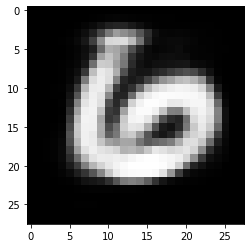

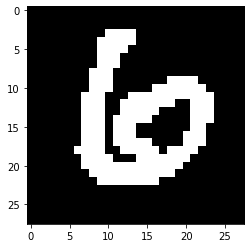

In [105]:
THRESHOLD = 0.5
import numpy as np
import numpy
#binarizing the image 0, 1
x_test = numpy.array(test_image > THRESHOLD, dtype=np.float32)
show_digit(test_image)
show_digit(x)

In [107]:
cross_entropy=bbrbm.get_reconstruction_cross_entropy(x)

In [108]:
print(cross_entropy)

tf.Tensor(124.198875, shape=(), dtype=float32)
